In [ ]:
import xgboost as xgb
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns 
color = sns.color_palette()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive",force_remount=True)


Mounted at /content/gdrive


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Colab_data/creditcard.csv",)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


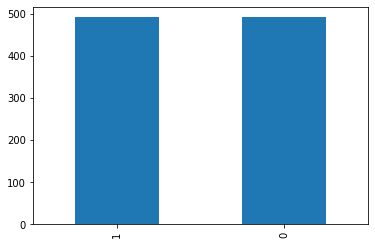

In [ ]:
suspicious_count = len(data[data['Class'] == 1])
non_suspicious_count = len(data[data['Class'] == 0])

sampled_non_suspicious = data[data['Class'] == 0].sample(n=suspicious_count)
suspicious = data[data['Class'] == 1]

sampled_non_suspicious.reset_index(drop=True, inplace=True)
suspicious.reset_index(drop=True, inplace=True)

balanced_data = pd.concat([sampled_non_suspicious, suspicious]).reset_index(drop=True);

balanced_data['Class'].value_counts().plot(kind='bar')

In [ ]:
y=balanced_data["Class"]
X=balanced_data.drop(columns=["Class"])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(X_test.shape)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)



(787, 30)
(197, 30)
(787,)
(197, 30)


In [ ]:
penalty = 'l2'   #Compared to L1, L2 is less sensitive to outliers
C = 1.0  ## regularization helps address overfitting by penalizing complexity.
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
logReg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, 
                            random_state=random_state, 
                            solver=solver, n_jobs=10)

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,
                                        columns=[0,1])

model = logReg
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)) ,y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
    X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
    y_train.iloc[cv_index]
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,
    model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
    model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold,
    predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)

loglossLogisticRegression = log_loss(y_train,
                                     predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.20618105226988778
CV Log Loss:  0.15419089803614155
Training Log Loss:  0.19783115984762345
CV Log Loss:  0.24435425706222702
Training Log Loss:  0.19404251916528523
CV Log Loss:  0.25285449124095455
Training Log Loss:  0.20454406500974706
CV Log Loss:  0.11576058081326407
Training Log Loss:  0.1943603566290039
CV Log Loss:  0.2671838137448698
Logistic Regression Log Loss:  0.2068495039085122


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/

In [ ]:
params_xGB = {
    "nthread":16,
    "learning rate":0.3,
    "gamma":0,
    "max_depth":6,
    "min_child_weight":1,
    "max_delta_step":0,
    "subsample":1.0,
    "colsample_bytree":1.0,
    "objective":"binary:logistic",
    "num_classes":1,
    "eval_metric":"logloss",
    "seed":2021,
    "silent":1,
  }
  


In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFold = pd.DataFrame(data=[],
                                       index=y_train.index,columns=["prediction"]
                                       )
for train_index,cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
  dCV = xgb.DMatrix(data=X_cv_fold)
  bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000,
               nfold=5, early_stopping_rounds=200,verbose_eval=50)
  best_rounds = np.argmin(bst["test-logloss-mean"])
  bst = xgb.train(params_xGB,dtrain,best_rounds)
  loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
  trainingScores.append(loglossTraining)
  predictionsBasedOnKFold.loc[X_cv_fold.index,"prediction"] = bst.predict(dCV)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFold.loc[X_cv_fold.index,"prediction"])
  cvScores.append(loglossCV)
  print("log loss: ", loglossTraining)
  print("CV log loss: ",loglossCV)

loglossXGBoostGradientBoosting = log_loss(y_train, predictionsBasedOnKFold.loc[:,"prediction"])
print("xgboost gradient boosting log loss: ", loglossXGBoostGradientBoosting)


[0]	train-logloss:0.474894+0.00249981	test-logloss:0.508447+0.00519025
[50]	train-logloss:0.0096778+0.000422383	test-logloss:0.223967+0.0873903
[100]	train-logloss:0.0065204+0.000174605	test-logloss:0.234444+0.0962513
[150]	train-logloss:0.0057922+0.000164865	test-logloss:0.240282+0.0999968
[200]	train-logloss:0.0053408+0.000177254	test-logloss:0.242143+0.101985
log loss:  0.03970688865305367
CV log loss:  0.15249893183344698
[0]	train-logloss:0.471797+0.00218601	test-logloss:0.508156+0.0064359
[50]	train-logloss:0.00892+0.000375454	test-logloss:0.202618+0.0609768
[100]	train-logloss:0.0062028+0.000133974	test-logloss:0.213297+0.0657216
[150]	train-logloss:0.0054954+0.000132177	test-logloss:0.217237+0.0685424
[200]	train-logloss:0.0050672+0.000122102	test-logloss:0.221028+0.0688151
log loss:  0.029230921681739377
CV log loss:  0.3075977394511679
[0]	train-logloss:0.477733+0.00424025	test-logloss:0.495859+0.010888
[50]	train-logloss:0.009264+0.000354856	test-logloss:0.218253+0.0705007
[

In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
    X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
    y_train.iloc[cv_index]
    dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=X_cv_fold)
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000,
                 nfold=5, early_stopping_rounds=200, verbose_eval=50)
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
    bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, \
                         predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)

loglossXGBoostGradientBoosting = \
log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

NameError: ignored

Text(0.5, 1.0, 'precision-recall curve: average precision=0.97')

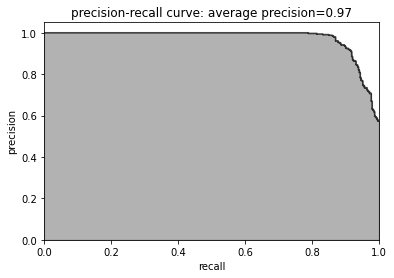

In [ ]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]],axis=1)
preds.columns = ["trueLabel","prediction"]
predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds["trueLabel"],preds["prediction"])
average_precision = average_precision_score(preds["trueLabel"],preds["prediction"])

plt.step(recall,precision, color="k",alpha = 0.7,where="post")
plt.fill_between(recall,precision,step="post",alpha=0.3,color="k")
plt.xlabel("recall")
plt.ylabel("precision")
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title("precision-recall curve: average precision={0:0.2f}".format(average_precision))


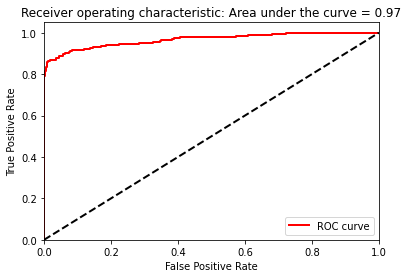

In [ ]:
fpr, tpr, thresholds = roc_curve(preds["trueLabel"],preds["prediction"])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()
